In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import geo_tools, nc_tools, tidetools
import xarray as xr
import glob
import datetime

%matplotlib inline

In [2]:
from matplotlib.colors import LogNorm

In [3]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
ferry_data = 'https://salishsea.eos.ubc.ca/erddap/tabledap/ubcONCTWDP1mV1'
bathy, X, Y = tidetools.get_bathy_data(grid)
ferry = nc.Dataset(ferry_data)

In [4]:
threemonthsa = sorted(glob.glob('/ocean/vdo/MEOPAR/completed-runs/threemonthsa_2/test*/*1h*grid_T*'))

In [5]:
threemonthsb = sorted(glob.glob('/ocean/vdo/MEOPAR/completed-runs/threemonthsb_2/test*/*1h*grid_T*'))

In [36]:
threemonthsbase = sorted(glob.glob('/ocean/vdo/MEOPAR/completed-runs/threemonthsbase_2/test*/*1h*grid_T*'))

In [7]:
mesh_mask = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
tmask = mesh_mask.variables['tmask'][:]

In [8]:
with nc_tools.scDataset(threemonthsa) as f:
    threemonthsa_sal = f.variables['vosaline'][:,1,...]
    print('salinity is done')
    threemonthsa_temp = f.variables['votemper'][:,1,...]
    print('temperature is done')
    timesa = f.variables['time_counter'][:]
    print('time is done')

salinity is done
temperature is done
time is done


In [33]:
nc.num2date(ferry.variables['s.time'][1246200], ferry.variables['s.time'].units)

datetime.datetime(2017, 6, 4, 10, 0)

In [42]:
nc.num2date(ferry.variables['s.time'][1126200], ferry.variables['s.time'].units)

datetime.datetime(2017, 3, 7, 2, 0)

In [38]:
with nc_tools.scDataset(threemonthsb) as f:
    threemonthsb_sal = f.variables['vosaline'][:,1,...]
    print('salinity is done')
    threemonthsb_temp = f.variables['votemper'][:,1,...]
    print('temperature is done')
    timesb = f.variables['time_counter'][:]
    print('time is done')

salinity is done
temperature is done
time is done


In [39]:
with nc_tools.scDataset(threemonthsbase) as f:
    threemonthsbase_sal = f.variables['vosaline'][:,1,...]
    print('salinity is done')
    threemonthsbase_temp = f.variables['votemper'][:,1,...]
    print('temperature is done')
    timesbase = f.variables['time_counter'][:]
    print('time is done')

salinity is done
temperature is done
time is done


In [40]:
h = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/threemonthbase/testA/SalishSea_1h_20170307_20170316_grid_U_20170313-20170313.nc')

In [41]:
converted_timesa = nc.num2date(timesa, h.variables['time_counter'].units)
converted_timesb = nc.num2date(timesb, h.variables['time_counter'].units)
converted_timesbase = nc.num2date(timesbase, h.variables['time_counter'].units)

In [43]:
list_of_model_sals = np.array([])
list_of_model_temps = np.array([])
list_of_ferry_sals = np.array([])
list_of_ferry_temps = np.array([])
unit = ferry.variables['s.time'].units
for n in range(1126200,1246200):
    if ((ferry.variables['s.latitude'][n].mask == False) 
        and (ferry.variables['s.salinity'][n].mask == False)):
        Yind, Xind = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                        ferry.variables['s.latitude'][n], 
                                                        X, Y, land_mask = bathy.mask)
        if tmask[0,1,Yind, Xind] == 1:
            date = nc.num2date(ferry.variables['s.time'][n], unit)
            if date.minute <= 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
                index = np.argmin(np.abs(converted_timesa - date))
                delta = (date - before).seconds / 3600
                s_val = ((delta * (threemonthsa_sal[index-1, Yind, Xind])) + 
                       (1- delta)*(threemonthsa_sal[index, Yind, Xind]))
                t_val = ((delta * (threemonthsa_temp[index-1, Yind, Xind])) + 
                       (1- delta)*(threemonthsa_temp[index, Yind, Xind]))
            if date.minute > 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                       hour = (date.hour), minute = 30)
                index = np.argmin(np.abs(converted_timesa - date))
                delta = (date - before).seconds / 3600
                s_val = ((delta * (threemonthsa_sal[index, Yind, Xind])) + 
                       (1- delta)*(threemonthsa_sal[index+1, Yind, Xind]))
                t_val = ((delta * (threemonthsa_temp[index, Yind, Xind])) + 
                       (1- delta)*(threemonthsa_temp[index+1, Yind, Xind]))
            list_of_ferry_sals = np.append(list_of_ferry_sals, ferry.variables['s.salinity'][n])
            list_of_ferry_temps = np.append(list_of_ferry_temps, ferry.variables['s.temperature'][n])
            list_of_model_sals = np.append(list_of_model_sals, s_val)
            list_of_model_temps = np.append(list_of_model_temps, t_val)

bias =  2.4005784593
RMSE = 5.3725159967
Willmott = 0.761063933603


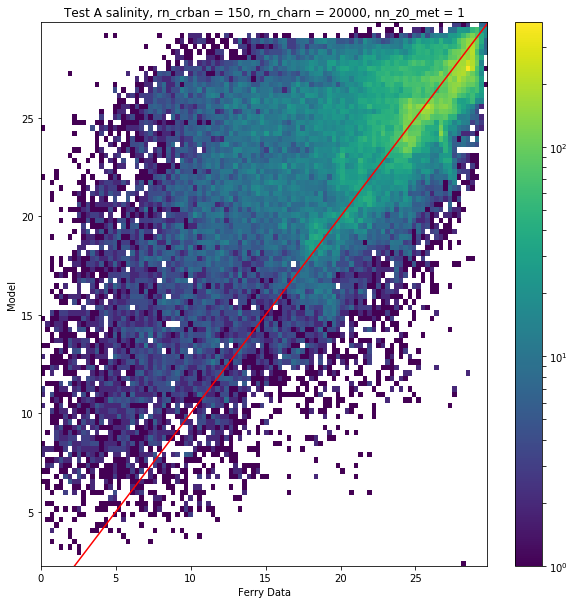

In [45]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_ferry_sals, list_of_model_sals, bins = 100, norm=LogNorm())
im
fig.colorbar(im, ax=ax)
ax.set_xlabel('Ferry Data')
ax.set_ylabel('Model')
ax.set_title('Test A salinity, rn_crban = 150, rn_charn = 20000, nn_z0_met = 1')
ax.plot(np.arange(0,31), np.arange(0,31), 'r-')
print('bias =  ' + str(-np.mean(list_of_ferry_sals) + np.mean(list_of_model_sals)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_sals - list_of_ferry_sals)**2) / len(list_of_model_sals))))
xbar = np.mean(list_of_ferry_sals)
print('Willmott = ' + str(1-(np.sum((list_of_model_sals - list_of_ferry_sals)**2)  / 
                             np.sum((np.abs(list_of_model_sals - xbar) + np.abs(list_of_ferry_sals - xbar))**2))))

In [48]:
list_of_modelb_sals = np.array([])
list_of_modelb_temps = np.array([])
list_of_ferryb_sals = np.array([])
list_of_ferryb_temps = np.array([])
unit = ferry.variables['s.time'].units
for n in range(1126200,1246200):
    if ((ferry.variables['s.latitude'][n].mask == False) 
        and (ferry.variables['s.salinity'][n].mask == False)):
        Yind, Xind = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                        ferry.variables['s.latitude'][n], 
                                                        X, Y, land_mask = bathy.mask)
        date = nc.num2date(ferry.variables['s.time'][n], unit)
        if date.minute <= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            index = np.argmin(np.abs(converted_timesb - date))
            delta = (date - before).seconds / 3600
            s_val = ((delta * (threemonthsb_sal[index-1, Yind, Xind])) + 
                   (1- delta)*(threemonthsb_sal[index, Yind, Xind]))
            t_val = ((delta * (threemonthsb_temp[index-1, Yind, Xind])) + 
                   (1- delta)*(threemonthsb_temp[index, Yind, Xind]))
        if date.minute > 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            index = np.argmin(np.abs(converted_timesb - date))
            delta = (date - before).seconds / 3600
            s_val = ((delta * (threemonthsb_sal[index, Yind, Xind])) + 
                   (1- delta)*(threemonthsb_sal[index+1, Yind, Xind]))
            t_val = ((delta * (threemonthsb_temp[index, Yind, Xind])) + 
                   (1- delta)*(threemonthsb_temp[index+1, Yind, Xind]))
        list_of_ferryb_sals = np.append(list_of_ferryb_sals, 
                                        ferry.variables['s.salinity'][n])
        list_of_ferryb_temps = np.append(list_of_ferryb_temps, 
                                         ferry.variables['s.temperature'][n])
        list_of_modelb_sals = np.append(list_of_modelb_sals, s_val)
        list_of_modelb_temps = np.append(list_of_modelb_temps, t_val)

bias =  2.24554836855
RMSE = 5.33063675025
Willmott = 0.762250776764


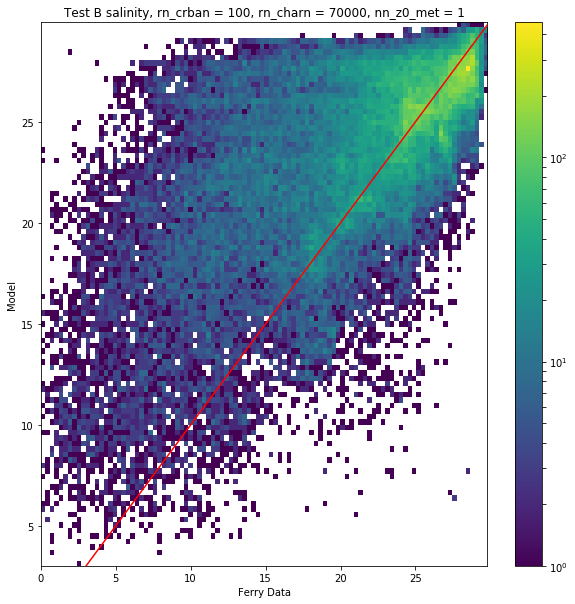

In [49]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_ferryb_sals, list_of_modelb_sals, bins = 100, norm=LogNorm())
im
fig.colorbar(im, ax=ax)
ax.set_xlabel('Ferry Data')
ax.set_ylabel('Model')
ax.set_title('Test B salinity, rn_crban = 100, rn_charn = 70000, nn_z0_met = 1')
ax.plot(np.arange(0,31), np.arange(0,31), 'r-')
print('bias =  ' + str(-np.mean(list_of_ferryb_sals) + np.mean(list_of_modelb_sals)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_modelb_sals - list_of_ferryb_sals)**2) / len(list_of_modelb_sals))))
xbar = np.mean(list_of_ferryb_sals)
print('Willmott = ' + str(1-(np.sum((list_of_modelb_sals - list_of_ferryb_sals)**2)  / 
                             np.sum((np.abs(list_of_modelb_sals - xbar) + np.abs(list_of_ferryb_sals - xbar))**2))))

In [50]:
list_of_modelbase_sals = np.array([])
list_of_modelbase_temps = np.array([])
list_of_ferrybase_sals = np.array([])
list_of_ferrybase_temps = np.array([])
unit = ferry.variables['s.time'].units
for n in range(1126200,1246200):
    if ((ferry.variables['s.latitude'][n].mask == False) 
        and (ferry.variables['s.salinity'][n].mask == False)):
        Yind, Xind = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                        ferry.variables['s.latitude'][n], 
                                                        X, Y, land_mask = bathy.mask)
        date = nc.num2date(ferry.variables['s.time'][n], unit)
        if date.minute <= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            index = np.argmin(np.abs(converted_timesbase - date))
            delta = (date - before).seconds / 3600
            s_val = ((delta * (threemonthsbase_sal[index-1, Yind, Xind])) + 
                   (1- delta)*(threemonthsbase_sal[index, Yind, Xind]))
            t_val = ((delta * (threemonthsbase_temp[index-1, Yind, Xind])) + 
                   (1- delta)*(threemonthsbase_temp[index, Yind, Xind]))
        if date.minute > 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            index = np.argmin(np.abs(converted_timesbase - date))
            delta = (date - before).seconds / 3600
            s_val = ((delta * (threemonthsbase_sal[index, Yind, Xind])) + 
                   (1- delta)*(threemonthsbase_sal[index+1, Yind, Xind]))
            t_val = ((delta * (threemonthsbase_temp[index, Yind, Xind])) + 
                   (1- delta)*(threemonthsbase_temp[index+1, Yind, Xind]))
        list_of_ferrybase_sals = np.append(list_of_ferrybase_sals, 
                                           ferry.variables['s.salinity'][n])
        list_of_ferrybase_temps = np.append(list_of_ferrybase_temps, 
                                            ferry.variables['s.temperature'][n])
        list_of_modelbase_sals = np.append(list_of_modelbase_sals, s_val)
        list_of_modelbase_temps = np.append(list_of_modelbase_temps, t_val)

bias =  2.07697099444
RMSE = 5.57899506709
Willmott = 0.735121854898


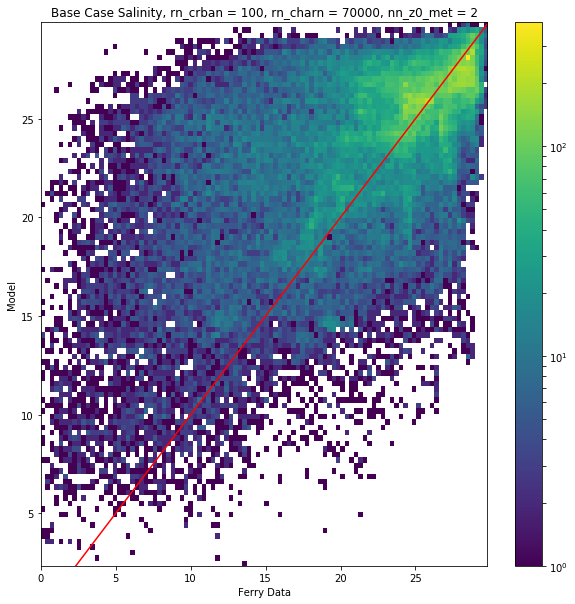

In [51]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_ferrybase_sals, 
                                list_of_modelbase_sals, bins = 100, norm=LogNorm())
im
fig.colorbar(im, ax=ax)
ax.set_xlabel('Ferry Data')
ax.set_ylabel('Model')
ax.set_title('Base Case Salinity, rn_crban = 100, rn_charn = 70000, nn_z0_met = 2')
ax.plot(np.arange(0,31), np.arange(0,31), 'r-')
print('bias =  ' + str(-np.mean(list_of_ferrybase_sals) + np.mean(list_of_modelbase_sals)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_modelbase_sals - list_of_ferrybase_sals)**2) 
                              / len(list_of_modelbase_sals))))
xbar = np.mean(list_of_ferrybase_sals)
print('Willmott = ' + str(1-(np.sum((list_of_modelbase_sals - list_of_ferrybase_sals)**2)  / 
                             np.sum((np.abs(list_of_modelbase_sals - xbar) 
                                     + np.abs(list_of_ferrybase_sals - xbar))**2))))

| Salinity  | Bias          | RMSE          | WS             |
|-----------|---------------|---------------|----------------|
| Base Case | 2.07697099444 | 5.57899506709 | 0.735121854898 |
| Test A    | 2.4005784593  | 5.3725159967  | 0.761063933603 |
| Test B    | 2.24554836855 | 5.33063675025 | 0.762250776764 |